## Методы машинного обучения в мониторинге акваторий с помощью ДЗЗ

Постановка задачи: на вход даются подаются спутниковые снимки акваторий в видимом диапазоне. Модель должна определять, есть ли на них загрязнения.

In [ ]:
#Here full imgs showing

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
np.random.seed(41)
import matplotlib.pyplot as plt
import cv2
import os
from VisExtract import VisExtract
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

%matplotlib inline

Импорт зависимостей. В классе VisExtract реализованно построение изображений в пространстве RGB. Также происходит StandartScale нормировка.

Выведем данные:

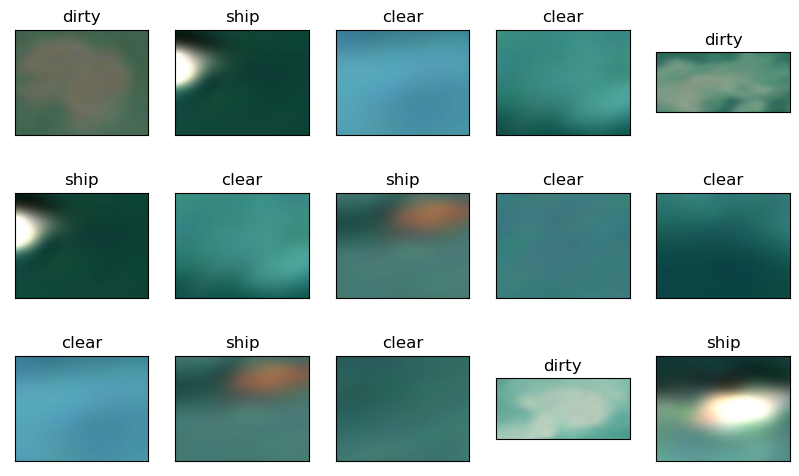

In [102]:
n_rows = 3
n_cols = 5

filelist = np.random.choice(os.listdir('data'), size=n_cols * n_cols)

f, axarr = plt.subplots(n_rows, n_cols, figsize=(10, 6))

l = lambda pth: cv2.cvtColor(cv2.imread(f'data/{pth}'), cv2.COLOR_RGB2BGR)

name = {'0': 'clear', '1': 'dirty', '2': 'ship'}


for i in range(1, n_rows + 1):
    for j in range(1, n_cols + 1):
        axarr[i - 1, j - 1].imshow(l(filelist[i * j]))
        axarr[i - 1, j - 1].set_xticks([]), axarr[i - 1, j - 1].set_yticks([])
        axarr[i - 1, j - 1].set_title(name[filelist[i * j][0]])

Представим данные в пространстве, координаты - средние значения RGB каналов.

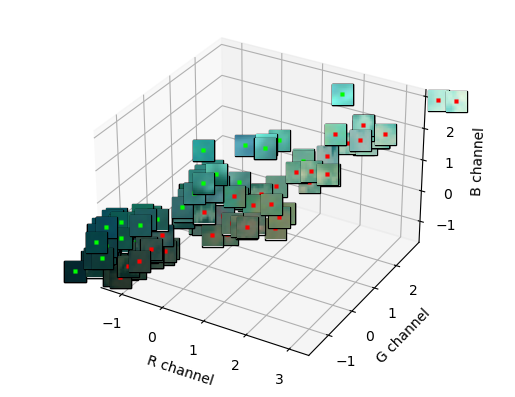

In [103]:
vis = VisExtract('data', len(os.listdir('data')), 'show')

Видно, что при таком количестве классов данные неплохо разделимы и линейно.

In [89]:
(trainData, testData, trainLabels, testLabels) = train_test_split(vis.data, vis.y, test_size=0.3, random_state=41)

Обучим модель логистической регрессии:

In [92]:
model = LogisticRegression(random_state=0, solver = 'lbfgs').fit(trainData, trainLabels)

Построим разделяющую плоскость:

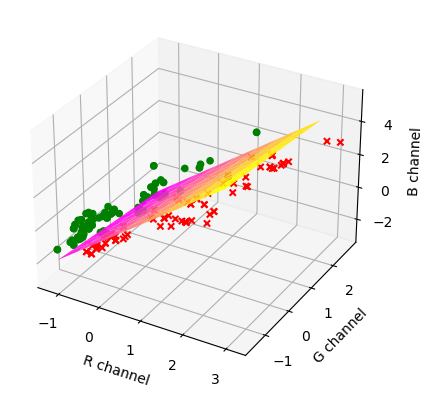

In [93]:
vis.add_hyperplane(list((model.coef_[0][0], model.coef_[0][1], model.coef_[0][2], model.intercept_[0])))

Выведем метрики качества:

In [94]:
Y_pred = model.predict(testData)
f1_score(Y_pred, testLabels), recall_score(Y_pred, testLabels), precision_score(Y_pred, testLabels), \
                                                                roc_auc_score(Y_pred, testLabels)

(0.962962962962963, 0.9285714285714286, 1.0, 0.9642857142857143)

Действительно, данные идеально разделимы линейно. Однако, это решение задачи классификации clear vs. dirty, но ведь на изображении могут быть и корабли. Смотрим:

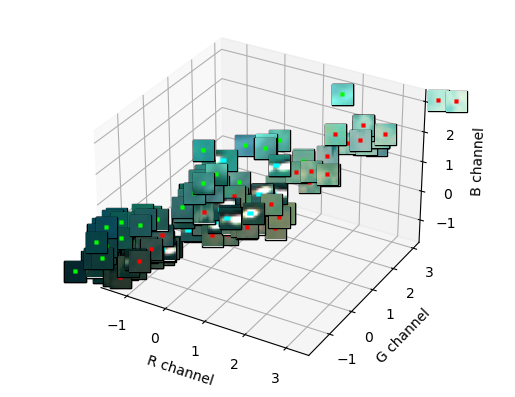

In [97]:
vis = VisExtract('data', len(os.listdir('data')), 'show', ships=True)

Если представить данные в RGB пространстве, используя как предиктор среднее значение по каналу RGB, то разделить их на три класса не выйдет. Попробуем использовать как предикторы гисторгаммы изображений.

In [83]:
def extract_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [110]:
imagePaths = sorted(list(os.listdir('data')))
data = []
labels = []

for file in imagePaths:
    image = cv2.imread(f'data/{file}', 1)
    label = file[0]
    hist = extract_histogram(image)
    data.append(hist)
    labels.append(label)

In [119]:
svc_model_ovr = OneVsRestClassifier(LinearSVC(random_state=9, C = 0.51)).fit(data, labels).predict(data)

array(['1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1